# PRL paper: https://journals-aps-org.libaccess.sjlibrary.org/prl/pdf/10.1103/PhysRevLett.126.213601

# Supplemental Material: https://journals-aps-org.libaccess.sjlibrary.org/prl/supplemental/10.1103/PhysRevLett.126.213601/SiVcompare_SM8edits2.pdf

In [25]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib_inline.backend_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import numba
import scipy.integrate as spint
color = 'k'

# parameters

In [26]:
hbar = 1.
mu = 1.
N = 1.
omega12 = 2. * np.pi
omega10_unstrained = 2. * np.pi

sigma = 0.2 * omega10_unstrained
gamma10 = 0.05 * sigma
Gamma10 = gamma10 * 1E-5

# colorbar function

In [27]:
# @numba.jit
def colorbar(mappable, plotcolor=color, label=None, fontsize=10):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label, color=plotcolor, size=fontsize)
    plt.tick_params(color=plotcolor, labelcolor=plotcolor, labelsize=fontsize)
    plt.sca(last_axes)

    ax.tick_params(color=plotcolor, labelcolor=plotcolor)

    return cbar

 # complex square function

In [28]:
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# density matrix element

## Eqn. (s11), index 10, 3rd order correction

In [29]:
@numba.jit
def rho_10_sig_3(omegat, omegatau, omega10):
    return -1j * abs2(mu) * mu / 8. / hbar**3. * (1j / (omegat - (omega10 - 1j*gamma10))) * (1j / (omegatau - (-omega10 - 1j*gamma10)))

## Eqn. (s15),  index 11, 4th order correction

In [30]:
@numba.jit
def rho_11_sig_4(omegat, omegatau, omega10):
    return abs2(mu)**2. / 16. / hbar**4. * (1j / (omegat - (omega10 - 1j*gamma10))) * (1j / (omegatau - (-omega10 - 1j*gamma10)))

# electron-phonon coupling function

## equation is written in text at the very beginning of p. 15 of the Supplementary Material

In [31]:
@numba.jit
def R(omega10, omega12):
    return omega12**2.

# $\tilde{E}^*_{LO}$ is the electric field?

# branching ratio

## Eqn. (s16)

In [32]:
@numba.jit
def B(omega10, omega12):
    return Gamma10 / (Gamma10 + R(omega10, omega12))

# Gaussian

## Eqn. (s19)

In [33]:
@numba.jit
def G(omega10):
    return N / sigma / np.sqrt(2. * np.pi) * np.exp(-(omega10 - omega10_unstrained)**2. / 2. / sigma**2.)

# Infinite integral

In [34]:
@numba.jit
def infint(argu):
    return spint.quad_vec(argu, -np.inf, np.inf)

# creating mesh

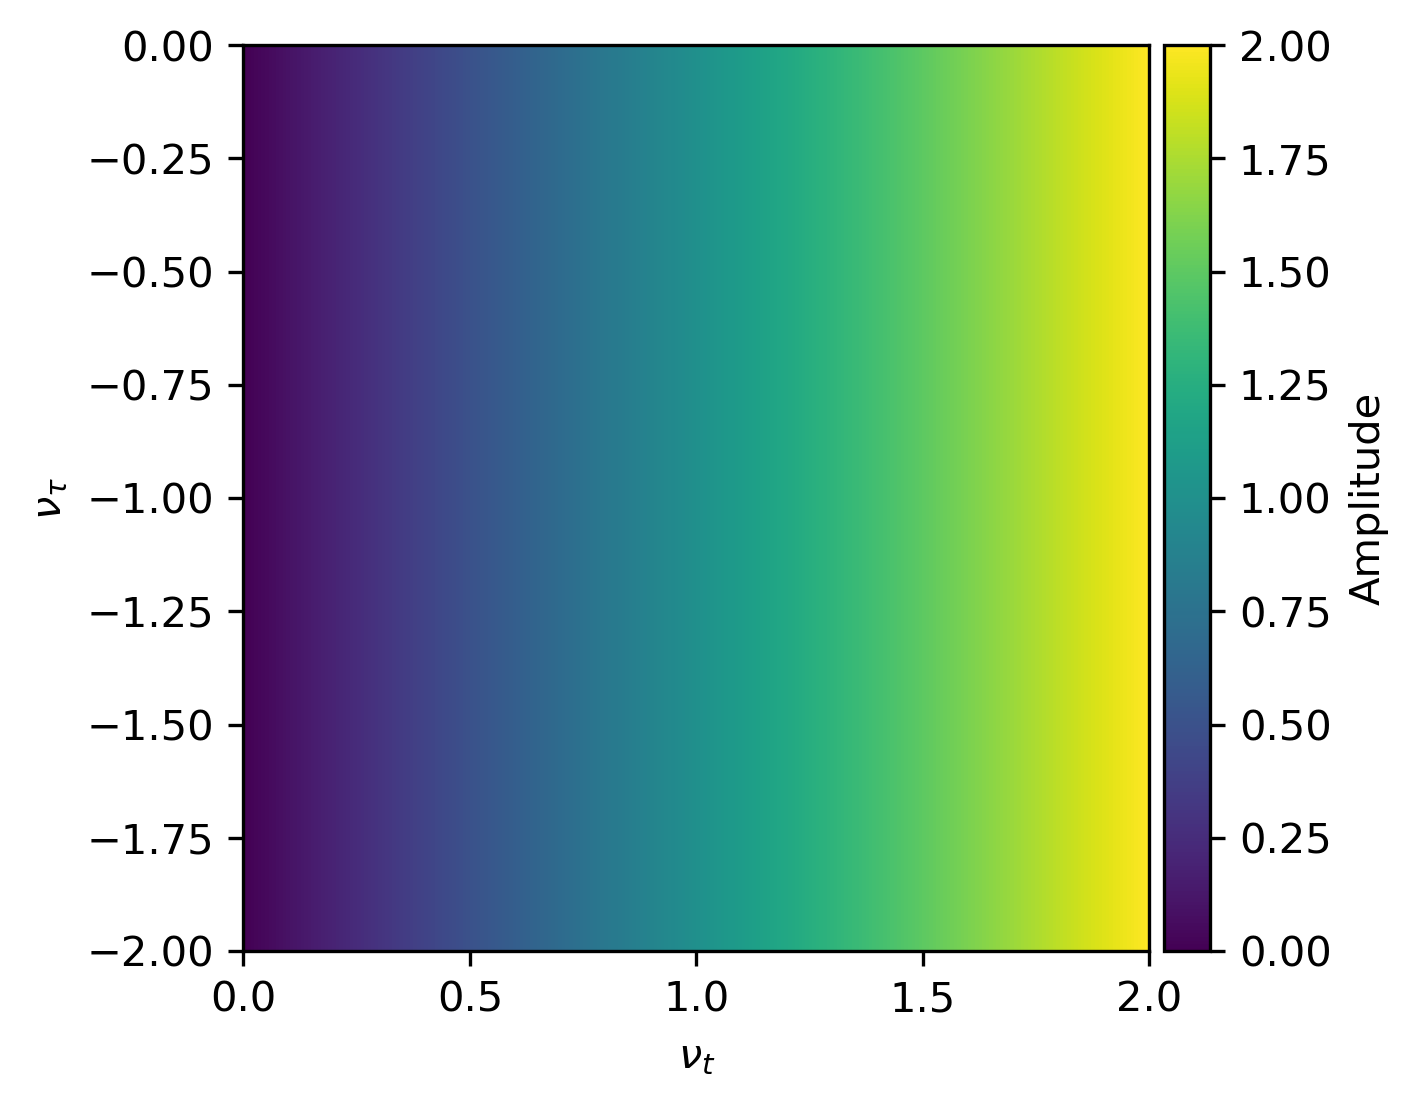

In [35]:
nu_t = np.linspace(0., 2., 500)
nu_tau = np.linspace(-2., 0., 500)
nu_t_mesh, nu_tau_mesh = np.meshgrid(nu_t, nu_tau, indexing='xy')
plt.figure(dpi=300)
im = plt.imshow(nu_t_mesh, origin='lower', extent=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau)))
plt.tick_params(color=color, labelcolor=color)
plt.xlabel(r'$\nu_t$', color=color)
plt.ylabel(r'$\nu_\tau$', color=color)
colorbar(im, color, 'Amplitude')
plt.show()

# converting to angular frequency

In [36]:
omegat_mesh = 2. * np.pi * nu_t_mesh
omegatau_mesh = 2. * np.pi * nu_tau_mesh

# computing the integral using https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad_vec.html

## Eqn. (s20)

In [37]:
argu = lambda omega10: G(omega10) * 1j * np.conj(mu) * rho_10_sig_3(omegat_mesh, omegatau_mesh, omega10)
I_tot_het, int_err_het = infint(argu)

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_5400/3005950524.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "infint" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_5400/3005950524.py (3)

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_5400/3005950524.py", line 3:
<source missing, REPL/exec in use?>

  @numba.jit
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "infint" was compiled in object mode without forceobj=True.

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_5400/3005950524.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDep

## Eqn. (s21)

In [38]:
argu = lambda omega10: G(omega10) * B(omega10, omega12) * rho_11_sig_4(omegat_mesh, omegatau_mesh, omega10)
I_tot_PL, int_err_PL = infint(argu)

# Plotting Heterodyne detection vs. PL detection simulation results

## Fig. S9(a)

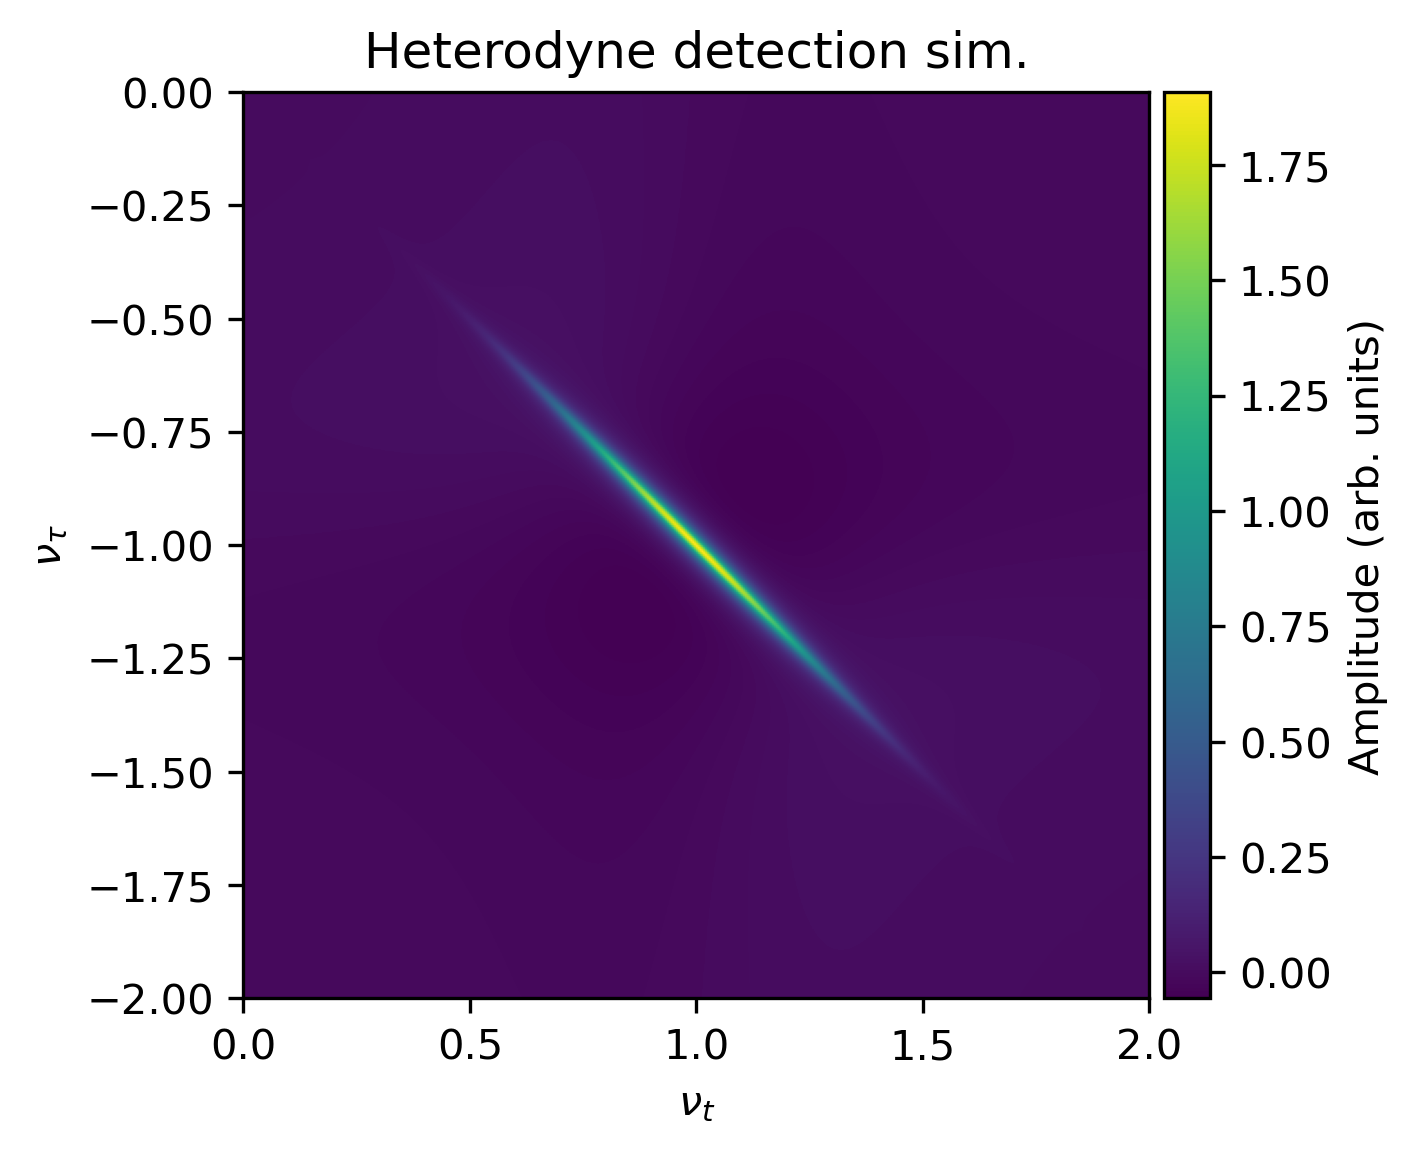

In [39]:
fig = plt.figure(dpi=300)
im = plt.imshow(I_tot_het.real, origin='lower', extent=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau)))
plt.tick_params(color=color, labelcolor=color)
plt.xlabel(r'$\nu_t$', color=color)
plt.ylabel(r'$\nu_\tau$', color=color)
plt.title('Heterodyne detection sim.', color=color)
colorbar(im, color, 'Amplitude (arb. units)')
plt.show()
fig.savefig("/Users/tommychin/Documents/research/Smallwood_research/testVectorImage.svg", dpi=1000, format='svg')

## Fig. S9(b)

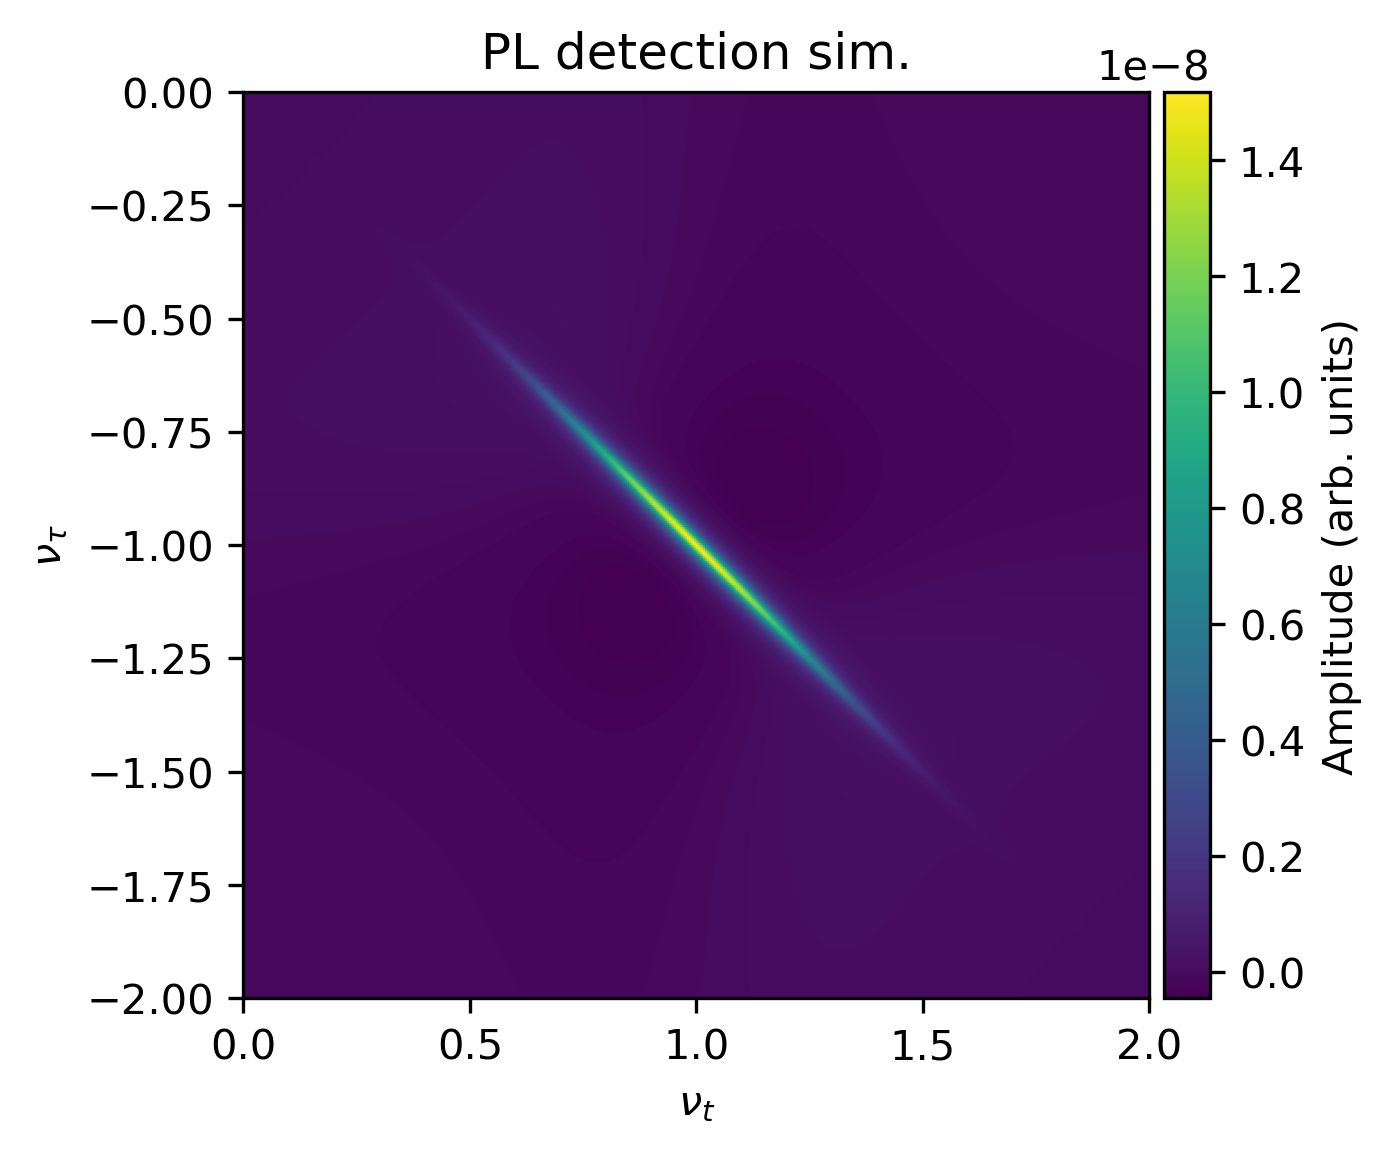

In [40]:
plt.figure(dpi=300)
im = plt.imshow(I_tot_PL.real, origin='lower', extent=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau)))
plt.tick_params(color=color, labelcolor=color)
plt.xlabel(r'$\nu_t$', color=color)
plt.ylabel(r'$\nu_\tau$', color=color)
plt.title('PL detection sim.', color=color)
colorbar(im, color, 'Amplitude (arb. units)')
plt.show()